In [ ]:
#!pip install tensorflow -qqq
#!pip install keras -qqq
#!pip install yfinance -qqq

In [1]:
import tensorflow as tf
import keras
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Check TensorFlow version
print("TensorFlow Version: ", tf.__version__)

TensorFlow Version:  2.13.0


In [2]:
# Fetch AAPL data
aapl_data = yf.download('AAPL', start='2020-01-01', end='2024-01-01')

# Display the first few rows of the dataframe
aapl_data.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,74.059998,75.150002,73.797501,75.087502,73.059418,135480400
2020-01-03,74.287498,75.144997,74.125000,74.357498,72.349136,146322800
2020-01-06,73.447502,74.989998,73.187500,74.949997,72.925644,118387200
2020-01-07,74.959999,75.224998,74.370003,74.597504,72.582657,108872000
2020-01-08,74.290001,76.110001,74.290001,75.797501,73.750237,132079200


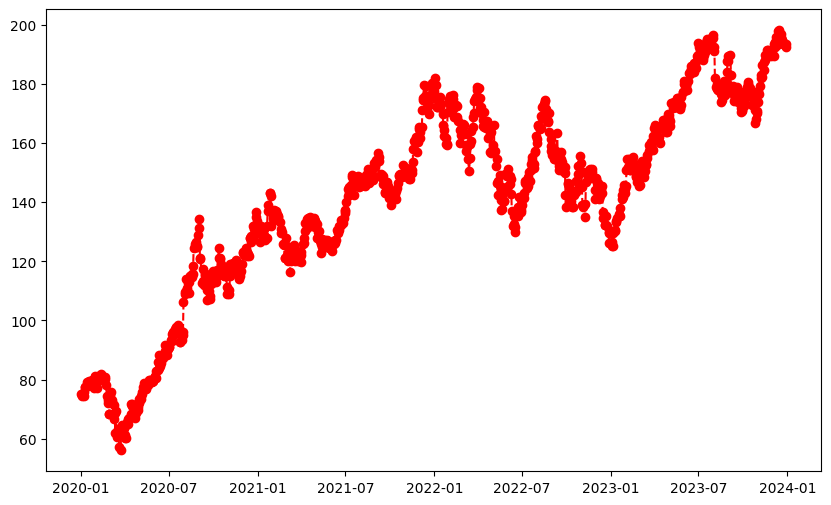

In [9]:
plt.figure(figsize=(10,6))
plt.plot(aapl_data.index, aapl_data['Close'], linestyle='dashed', marker='o', color='red')

In [3]:
#Data Cleaning / Handling Anomalies
# Checking for missing values
aapl_data.isnull().sum()

# Filling missing values, if any
aapl_data.fillna(method='ffill', inplace=True)

In [10]:
#Feature Selection
#Data Normalization
#For our model, we’ll use ‘Close’ prices, but you can experiment with additional features like ‘Open’, ‘High’, ‘Low’, and ‘Volume’.
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
aapl_data_scaled = scaler.fit_transform(aapl_data['Close'].values.reshape(-1,1))

In [ ]:
#Creating Sequences for work (viz. coose a sequence length, like 60 days)
X = []
y = []

for i in range(60, len(aapl_data_scaled)):
    X.append(aapl_data_scaled[i-60:i, 0])
    y.append(aapl_data_scaled[i, 0])

In [ ]:
#Train-Test Split
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [ ]:
#reshape our data into a 3D format [samples, time steps, features] required by LSTM layers
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [ ]:
#MODEL BUILDING
#Creating LSTM Layers
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, AdditiveAttention, Permute, Reshape, Multiply

model = Sequential()

# Adding LSTM layers with return_sequences=True
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=True))

In [ ]:
#Integrating the Attention Mechanism
# Adding self-attention mechanism
# The attention mechanism
attention = AdditiveAttention(name='attention_weight')
# Permute and reshape for compatibility
model.add(Permute((2, 1))) 
model.add(Reshape((-1, X_train.shape[1])))
attention_result = attention([model.output, model.output])
multiply_layer = Multiply()([model.output, attention_result])
# Return to original shape
model.add(Permute((2, 1))) 
model.add(Reshape((-1, 50)))

# Adding a Flatten layer before the final Dense layer
model.add(tf.keras.layers.Flatten())

# Final Dense layer
model.add(Dense(1))

In [ ]:
#preventing overfitting
# Adding Dropout and Batch Normalization
from keras.layers import BatchNormalization
model.add(Dropout(0.2))
model.add(BatchNormalization())

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
model.summary()

In [ ]:
# Assuming X_train and y_train are already defined and preprocessed
history = model.fit(X_train, y_train, epochs=100, batch_size=25, validation_split=0.2)

In [ ]:
# Convert X_test and y_test to Numpy arrays if they are not already
X_test = np.array(X_test)
y_test = np.array(y_test)

# Ensure X_test is reshaped similarly to how X_train was reshaped
# This depends on how you preprocessed the training data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Now evaluate the model on the test data
test_loss = model.evaluate(X_test, y_test)
print("Test Loss: ", test_loss)

In [ ]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(X_train, y_train, epochs=100, batch_size=25, validation_split=0.2, callbacks=[early_stopping])

In [ ]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TensorBoard, CSVLogger
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(X_train, y_train, epochs=100, batch_size=25, validation_split=0.2, callbacks=[early_stopping])
# Callback to save the model periodically
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')

# Callback to reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

# Callback for TensorBoard
tensorboard = TensorBoard(log_dir='./logs')

# Callback to log details to a CSV file
csv_logger = CSVLogger('training_log.csv')

# Combining all callbacks
callbacks_list = [early_stopping, model_checkpoint, reduce_lr, tensorboard, csv_logger]

# Fit the model with the callbacks
history = model.fit(X_train, y_train, epochs=100, batch_size=25, validation_split=0.2, callbacks=callbacks_list)